In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn ML Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_validate,ShuffleSplit, GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
import category_encoders as ce
from sklearn.feature_selection import SelectPercentile
import warnings
warnings.filterwarnings('ignore')

In [28]:
df = pd.read_csv('listings_cleaned.csv')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   neighbourhood_cleansed  3585 non-null   object 
 1   property_type           3585 non-null   object 
 2   room_type               3585 non-null   object 
 3   accommodates            3585 non-null   int64  
 4   bathrooms               3585 non-null   float64
 5   instant_bookable        3585 non-null   object 
 6   bedrooms                3585 non-null   float64
 7   bed_type                3585 non-null   object 
 8   beds                    3585 non-null   float64
 9   price                   3585 non-null   float64
 10  cleaning_fee            3585 non-null   int64  
 11  availability_365        3585 non-null   int64  
 12  guests_included         3585 non-null   int64  
 13  extra_people            3585 non-null   int64  
 14  security_deposit        3585 non-null   

In [30]:
df.drop(['price'],axis=1, inplace=True)
# Replacing columns with f/t with 0/1
df.instant_bookable.replace({'f': 0, 't': 1}, inplace=True)

In [31]:
df.columns

Index(['neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'instant_bookable', 'bedrooms', 'bed_type', 'beds',
       'cleaning_fee', 'availability_365', 'guests_included', 'extra_people',
       'security_deposit', 'minimum_nights', 'cancellation_policy',
       'breakfast', 'high_end_electronics', 'smoke_detector', 'pets_allowed',
       'secure', 'washing_machine', 'heating', 'Hot_Tub', 'hair_dryer',
       'hangers', 'elevator', 'fire_extinguisher', 'free_parking', 'gym', 'tv',
       'kitchen', 'workspace', 'room_key', 'pool', 'wheelchair_access',
       'internet', 'firstAid_kit', 'log_price'],
      dtype='object')

In [32]:
features = df.drop(columns='log_price')
target = df['log_price']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state = 2021)

## Pipeline 

In [33]:
numeric_features = [ 'accommodates','bathrooms', 'bedrooms', 'beds', 'cleaning_fee',
                    'availability_365', 'guests_included', 'extra_people','security_deposit',
                    'minimum_nights', 'breakfast', 'high_end_electronics',
                    'smoke_detector', 'pets_allowed', 'secure', 'washing_machine','heating',
                    'Hot_Tub', 'hair_dryer', 'hangers', 'elevator','fire_extinguisher',
                    'free_parking', 'gym', 'tv', 'kitchen','workspace', 'room_key', 'pool',
                    'wheelchair_access', 'internet','firstAid_kit']

categorical_features = ['neighbourhood_cleansed', 
                        'property_type','room_type','bed_type', 
                        'cancellation_policy','instant_bookable']

numeric_transformer = Pipeline([('scaler', RobustScaler())
                               ])

categorical_transformer = Pipeline([('binary', ce.BinaryEncoder())
                                   ])

preprocessor = ColumnTransformer([
        ('num', numeric_transformer,numeric_features),
        ('cat', categorical_transformer, categorical_features)], remainder = 'passthrough')


In [34]:
### build evaluation function for default

def price_taget(model,train_features, train_target,test_features,test_target):
    vals = dict()
    predictions = model.predict(test_features)
    MAE = mean_absolute_error(test_target, predictions)
    RMSE = np.sqrt(mean_squared_error(test_target, predictions))
    r2 = r2_score(test_target, predictions)
    df_results = pd.DataFrame({'Actual': test_target, 'Predicted': predictions})
    df_results['Residuals'] = (df_results['Actual']) - (df_results['Predicted'])
    plt.figure(figsize=(10,10)),
    sns.scatterplot(x=df_results.index, y=df_results.Residuals, alpha=0.5),
    plt.plot(np.repeat(0,df_results.index.max()), color='darkorange', linestyle='--'),
    plt.xlabel('Fitted Values'),
    plt.ylabel('Residuals')
          
    vals = dict()
    cv = ShuffleSplit(n_splits = 5, random_state=2021)
    val = cross_validate(model, train_features, train_target, cv=cv,
                            scoring=('r2'),
                        return_train_score=True)
    score = pd.DataFrame.from_dict(val, orient='index')
    scores = score.mean(axis=1)
    
    print('Model Performance')
    print(f"MAE: {round(MAE, 3)}")
    print(f"RMSE: {round(RMSE, 3)}")
    print(f"r2 : {round(r2, 3)}")
    vals['MAE'] = MAE
    vals['RMSE'] = RMSE
    vals['R2'] = r2
    print('Cross validation of the model')
    print(scores)
    print('residual data frame')
    print(df_results.head(20))
    vals['score'] = scores
    
    return vals
plt.show()

## 1. Default Parameter 

###  Models used*

The models used in this analysis can be grouped in three different types: (1) **linear models**, (2) **tree-based models** and (3) **clustering-like models**. There is a total of **6 models** used. 

##### **1. Linear models**

- ``LinearRegression`` Analisis Regresi Linear Sederhana – Regresi Linear Sederhana adalah Metode Statistik yang berfungsi untuk menguji sejauh mana hubungan sebab akibat antara Variabel Faktor Penyebab (X) terhadap Variabel Akibatnya. Faktor Penyebab pada umumnya dilambangkan dengan X atau disebut juga dengan Predictor sedangkan Variabel Akibat dilambangkan dengan Y atau disebut juga dengan Response. Regresi Linear Sederhana atau sering disingkat dengan SLR (Simple Linear Regression) juga merupakan salah satu Metode Statistik yang dipergunakan dalam produksi untuk melakukan peramalan ataupun prediksi tentang karakteristik kualitas maupun Kuantitas.


##### **2. Tree-based models**

- ``DecisionTreeRegressor`` Pohon keputusan membangun model regresi atau klasifikasi dalam bentuk struktur pohon. Ini memecah kumpulan data menjadi himpunan bagian yang lebih kecil dan lebih kecil sementara pada saat yang sama pohon keputusan terkait dikembangkan secara bertahap. Hasil akhirnya adalah pohon dengan simpul keputusan dan simpul daun [2]. Dalam konteks regresi, maka decision tree adalah regresi yang bersifat non-linear dan non-kontinu (diskret). maka ia adalah teknik pengambilan keputusan dengan analogi sebuah pohon memiliki banyak cabang/ akar. Di mana satu cabang akan bercabang lagi, kemudian bercabang lagi, dan seterusnya.

- ``GradientBoostingRegressor`` "Meningkatkan" dalam pembelajaran mesin adalah cara menggabungkan beberapa model sederhana ke dalam satu model komposit. Ini juga mengapa penguat dikenal sebagai model aditif, karena model sederhana (juga dikenal sebagai pembelajar lemah) ditambahkan satu per satu, sambil mempertahankan struktur yang ada dalam model tidak berubah. Saat kami menggabungkan semakin banyak model sederhana, model akhir yang lengkap menjadi prediktor yang lebih kuat. Istilah "gradien" dalam "peningkatan gradien" berasal dari fakta bahwa algoritme menggunakan penurunan gradien untuk meminimalkan kerugian.

- ``RandomForestRegressor`` Random forests or random decision forests are metode pembelajaran ansambel untuk klasifikasi, regresi, dan tugas lain yang beroperasi dengan membangun banyak pohon keputusan pada waktu pelatihan dan mengeluarkan kelas yang merupakan mode kelas (klasifikasi) atau prediksi rata-rata / rata-rata ( regresi) dari masing-masing pohon.

- ``XGBRegressor`` XGBoost adalah singkatan dari "Extreme Gradient Boosting", di mana istilah "Gradient Boosting" berasal dari kertas Pendekatan Fungsi Greedy: A Gradient Boosting Machine, oleh Friedman. XGBoost digunakan untuk masalah pembelajaran yang diawasi, di mana kami menggunakan data pelatihan (dengan beberapa fitur) $ x_i $ untuk memprediksi variabel target $ y_i $ [4].

##### **3. Clustering-like models**

- ``KNeighborsRegressor`` Regression based on *k-nearest neighbors*. Target diprediksi dengan interpolasi lokal dari target yang terkait dengan tetangga terdekat dalam set pelatihan.

 Metrics choosed to validate the models*
metrik yang digunakan untuk mengevaluasi model regresi adalah:

- **$R^2$** - Proporsi varian dalam variabel dependen yang dapat diprediksi dari variabel independen. Skor terbaik adalah 1.0 dan bisa negatif (karena model bisa menjadi lebih buruk secara sewenang-wenang). Model konstan yang selalu memprediksi nilai yang diharapkan dari y, dengan mengabaikan fitur masukan, akan mendapatkan skor R ^ 2 sebesar 0,0 
**$R^2$** Merupakan koefisien determinasi berganda dan metode untuk menemukan subset variabel independen yang paling baik memprediksi variabel dependen dengan regresi linier. Metode selalu mengidentifikasi model terbaik sebagai model dengan yang terbesar untuk setiap jumlah variabel yang dipertimbangkan.


#### ``LinearRegression``

Model Performance
MAE: 0.294
RMSE: 0.393
r2 : 0.636
Cross validation of the model
fit_time       0.124201
score_time     0.024579
test_score     0.616763
train_score    0.627154
dtype: float64
residual data frame
        Actual  Predicted  Residuals
2859  4.700480   5.287246  -0.586766
2905  4.189655   4.319117  -0.129463
893   3.931826   4.155981  -0.224156
483   3.931826   4.133684  -0.201859
1745  4.912655   4.416866   0.495789
3102  6.403574   5.541336   0.862238
2769  4.025352   4.307598  -0.282247
3557  4.110874   4.419015  -0.308141
844   5.860786   5.599596   0.261190
3549  4.394449   4.431088  -0.036639
1410  5.703782   5.320171   0.383611
2418  5.135798   5.374273  -0.238475
256   4.488636   4.628349  -0.139712
244   4.234107   4.445422  -0.211316
3550  4.736198   4.654448   0.081751
2088  5.398163   5.236578   0.161585
2981  4.158883   4.248211  -0.089328
2321  5.940171   5.530117   0.410054
289   4.430817   4.229951   0.200866
2701  4.110874   3.961173   0.149701


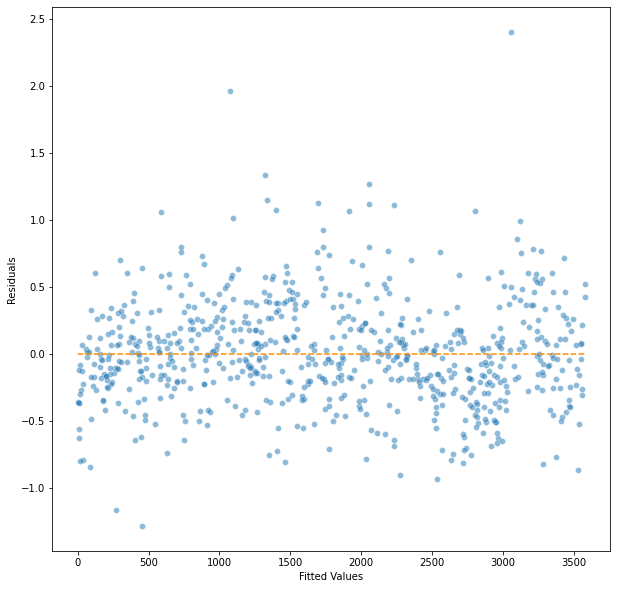

In [35]:
linreg = LinearRegression()
linreg_pipe = Pipeline([
    ('preprocessor',preprocessor),
      ('linear_regression',linreg)])
linreg_pipe.fit(X_train, y_train)
linreg_acc = price_taget(linreg_pipe,X_train,y_train,X_test,y_test)

Model pertama ini tidak cukup mampu membuat prediksi yang akurat: model ini memiliki $R ^ 2 = 0,60$ untuk data pelatihan dan $ R ^ 2 = 0,69$ untuk data pengujian.

Namun, tidak ada perbedaan besar antara error yang dibuat dalam set data pelatihan dan pengujian, sehingga terdapat **bias besar** dan **varian yang lebih kecil**, karena ini merupakan karakteristik model linier seperti `` LinearRegression `` model.

#### ``DecisionTreeRegressor``

Model Performance
MAE: 0.361
RMSE: 0.552
r2 : 0.281
Cross validation of the model
fit_time       0.119745
score_time     0.020171
test_score     0.274946
train_score    0.999383
dtype: float64
residual data frame
        Actual  Predicted  Residuals
2859  4.700480   4.836282  -0.135802
2905  4.189655   4.110874   0.078781
893   3.931826   4.442651  -0.510826
483   3.931826   3.526361   0.405465
1745  4.912655   4.262680   0.649975
3102  6.403574   6.403574   0.000000
2769  4.025352   3.912023   0.113329
3557  4.110874   4.382027  -0.271153
844   5.860786   5.525453   0.335333
3549  4.394449   4.406719  -0.012270
1410  5.703782   5.480639   0.223144
2418  5.135798   5.525453  -0.389655
256   4.488636   4.418841   0.069796
244   4.234107   4.276666  -0.042560
3550  4.736198   4.110874   0.625325
2088  5.398163   5.081404   0.316758
2981  4.158883   4.356709  -0.197826
2321  5.940171   5.298317   0.641854
289   4.430817   4.276666   0.154151
2701  4.110874   3.931826   0.179048


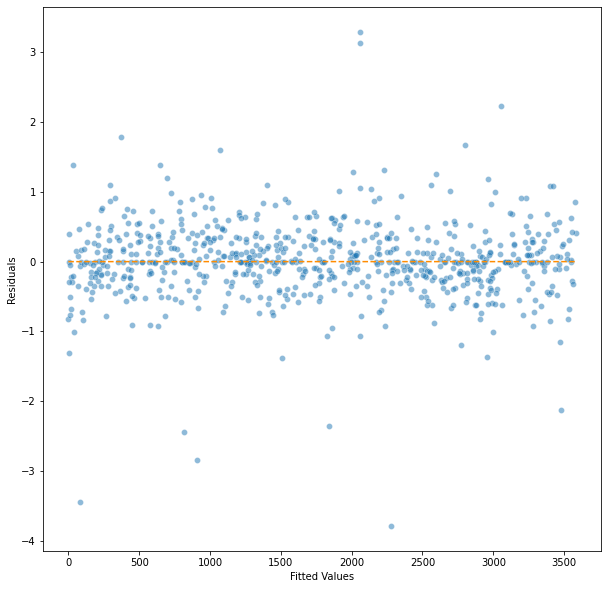

In [36]:
dtr = DecisionTreeRegressor()
dtr_pipe = Pipeline(
    [('preprocessor', preprocessor),
     ('tree', dtr)])
dtr_pipe.fit(X_train, y_train)
dtr_acc = price_taget(dtr_pipe,X_train,y_train,X_test,y_test)

#### ``GradientBoostingRegressor``

Model Performance
MAE: 0.261
RMSE: 0.347
r2 : 0.716
Cross validation of the model
fit_time       0.483713
score_time     0.022067
test_score     0.675583
train_score    0.733493
dtype: float64
residual data frame
        Actual  Predicted  Residuals
2859  4.700480   5.342897  -0.642416
2905  4.189655   4.232267  -0.042612
893   3.931826   4.213631  -0.281806
483   3.931826   4.120349  -0.188524
1745  4.912655   4.357107   0.555548
3102  6.403574   5.626875   0.776700
2769  4.025352   4.107071  -0.081720
3557  4.110874   4.459150  -0.348277
844   5.860786   5.933387  -0.072601
3549  4.394449   4.656308  -0.261859
1410  5.703782   5.438960   0.264822
2418  5.135798   5.389791  -0.253993
256   4.488636   4.478859   0.009777
244   4.234107   4.400097  -0.165990
3550  4.736198   4.889826  -0.153627
2088  5.398163   5.147829   0.250333
2981  4.158883   4.237837  -0.078954
2321  5.940171   5.463284   0.476888
289   4.430817   4.371446   0.059370
2701  4.110874   4.238927  -0.128053


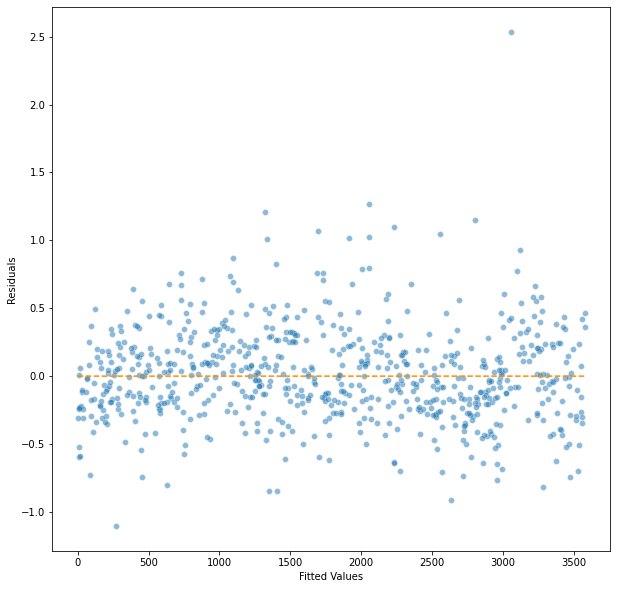

In [37]:
gbr = GradientBoostingRegressor()
gbr_pipe = Pipeline(
    [('preprocessor', preprocessor),
     ('boost',gbr)])
gbr_pipe.fit(X_train, y_train)
gbr_acc  = price_taget(gbr_pipe, X_train, y_train,X_test, y_test)

#### ``RandomForestRegressor``

Model Performance
MAE: 0.253
RMSE: 0.354
r2 : 0.704
Cross validation of the model
fit_time       1.723965
score_time     0.040754
test_score     0.681673
train_score    0.952453
dtype: float64
residual data frame
        Actual  Predicted  Residuals
2859  4.700480   5.319820  -0.619340
2905  4.189655   4.276818  -0.087163
893   3.931826   4.050326  -0.118501
483   3.931826   4.256274  -0.324448
1745  4.912655   4.311410   0.601245
3102  6.403574   6.063244   0.340330
2769  4.025352   4.178804  -0.153453
3557  4.110874   4.497084  -0.386210
844   5.860786   5.757811   0.102975
3549  4.394449   4.710655  -0.316205
1410  5.703782   5.451824   0.251959
2418  5.135798   5.271930  -0.136132
256   4.488636   4.432493   0.056143
244   4.234107   4.535606  -0.301499
3550  4.736198   4.733825   0.002373
2088  5.398163   5.248649   0.149513
2981  4.158883   4.345763  -0.186880
2321  5.940171   5.445371   0.494801
289   4.430817   4.417062   0.013755
2701  4.110874   4.213171  -0.102297


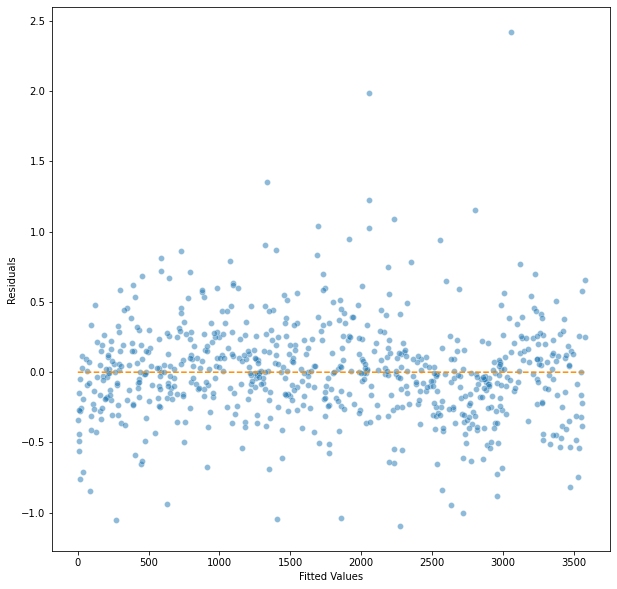

In [38]:
rfr = RandomForestRegressor()
rfr_pipe = Pipeline(
    [('preprocessor', preprocessor),
     ('random_forest',rfr)])
rfr_pipe.fit(X_train, y_train)
rfr_acc = price_taget(rfr_pipe, X_train, y_train, X_test, y_test)

#### ``XGBRegressor``

Model Performance
MAE: 0.252
RMSE: 0.352
r2 : 0.707
Cross validation of the model
fit_time       0.542775
score_time     0.032230
test_score     0.682574
train_score    0.972198
dtype: float64
residual data frame
        Actual  Predicted  Residuals
2859  4.700480   5.388859  -0.688379
2905  4.189655   4.043941   0.145714
893   3.931826   4.145249  -0.213423
483   3.931826   4.705052  -0.773227
1745  4.912655   4.547791   0.364863
3102  6.403574   6.203166   0.200408
2769  4.025352   3.938243   0.087109
3557  4.110874   4.498390  -0.387516
844   5.860786   6.039129  -0.178343
3549  4.394449   4.896736  -0.502287
1410  5.703782   5.581884   0.121898
2418  5.135798   5.357364  -0.221565
256   4.488636   4.376749   0.111887
244   4.234107   4.480756  -0.246649
3550  4.736198   4.465765   0.270434
2088  5.398163   5.295676   0.102487
2981  4.158883   4.328758  -0.169875
2321  5.940171   5.460428   0.479743
289   4.430817   4.379869   0.050948
2701  4.110874   4.249914  -0.139040


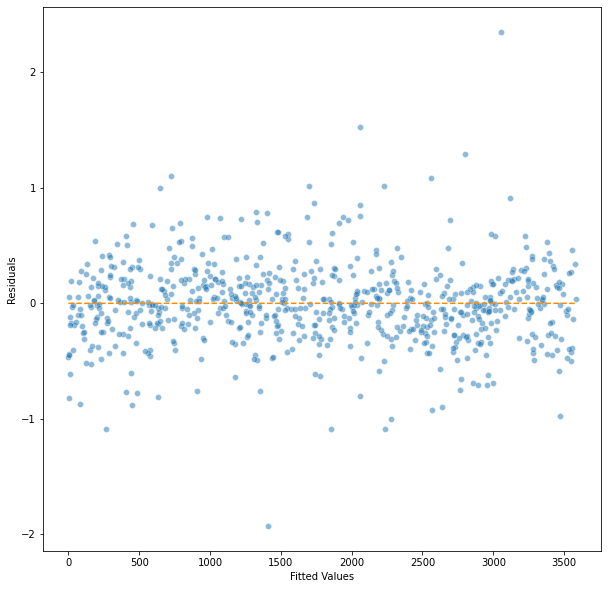

In [39]:
xgb = XGBRegressor()
xgb_pipe = Pipeline(
    [('preprocessor', preprocessor),
     ('boost',xgb)])
xgb_pipe.fit(X_train, y_train)
xgb_acc = price_taget(xgb_pipe,X_train, y_train, X_test, y_test)

#### ``KNeighborsRegressor``

Model Performance
MAE: 0.284
RMSE: 0.383
r2 : 0.653
Cross validation of the model
fit_time       0.102179
score_time     0.045464
test_score     0.618978
train_score    0.729562
dtype: float64
residual data frame
        Actual  Predicted  Residuals
2859  4.700480   5.260204  -0.559724
2905  4.189655   4.207827  -0.018172
893   3.931826   4.183464  -0.251638
483   3.931826   4.475283  -0.543458
1745  4.912655   4.734158   0.178497
3102  6.403574   5.861376   0.542198
2769  4.025352   4.136764  -0.111412
3557  4.110874   4.525535  -0.414661
844   5.860786   6.054096  -0.193310
3549  4.394449   4.678931  -0.284482
1410  5.703782   5.436313   0.267470
2418  5.135798   5.325679  -0.189880
256   4.488636   4.451803   0.036833
244   4.234107   4.367520  -0.133413
3550  4.736198   5.336254  -0.600055
2088  5.398163   5.350095   0.048068
2981  4.158883   4.330344  -0.171461
2321  5.940171   5.393249   0.546922
289   4.430817   4.434861  -0.004044
2701  4.110874   4.291869  -0.180995


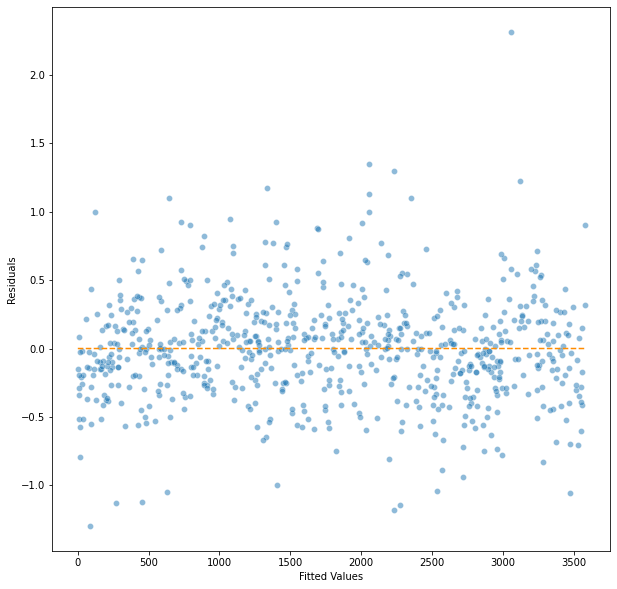

In [40]:
knr = KNeighborsRegressor()
knr_pipe = Pipeline(
    [('preprocessor', preprocessor),
     ('KNR',knr)])
knr_pipe.fit(X_train, y_train)
knr_acc = price_taget(knr_pipe, X_train, y_train,X_test, y_test)

## 2. base model with feature selection

#### ``LinearRegression``

Model Performance
MAE: 0.301
RMSE: 0.402
r2 : 0.618
Cross validation of the model
fit_time       0.149804
score_time     0.020721
test_score     0.599342
train_score    0.602883
dtype: float64
residual data frame
        Actual  Predicted  Residuals
2859  4.700480   5.317758  -0.617278
2905  4.189655   4.311501  -0.121846
893   3.931826   4.211304  -0.279478
483   3.931826   4.241122  -0.309296
1745  4.912655   4.471635   0.441020
3102  6.403574   5.671974   0.731600
2769  4.025352   4.340448  -0.315097
3557  4.110874   4.449688  -0.338814
844   5.860786   5.600747   0.260039
3549  4.394449   4.394778  -0.000329
1410  5.703782   5.382405   0.321378
2418  5.135798   5.393131  -0.257333
256   4.488636   4.427026   0.061610
244   4.234107   4.385396  -0.151290
3550  4.736198   4.792976  -0.056778
2088  5.398163   5.178306   0.219857
2981  4.158883   4.199697  -0.040814
2321  5.940171   5.509398   0.430773
289   4.430817   4.264908   0.165909
2701  4.110874   4.141696  -0.030822


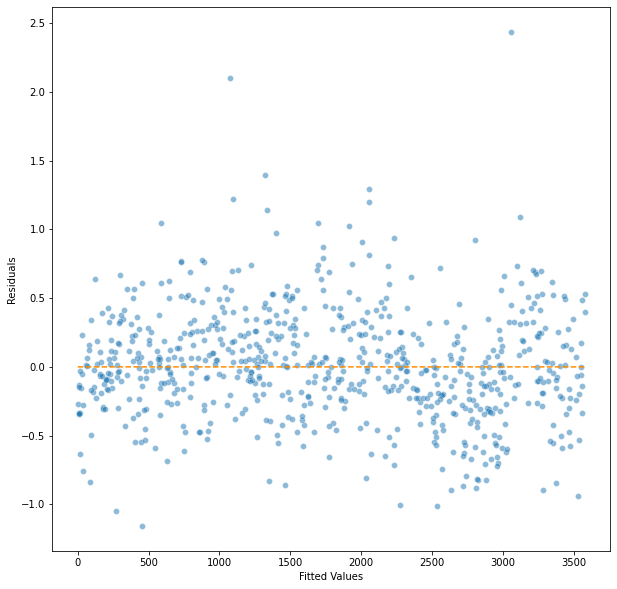

In [41]:
linreg2 = LinearRegression()
linreg2_pipe = Pipeline([('preprocessor',preprocessor),
                         ('percen', SelectPercentile(percentile=50)),
                         ('linear_regression',linreg2)
                        ])
linreg2_pipe.fit(X_train, y_train)
linreg_acc2 = price_taget(linreg2_pipe,X_train,y_train,X_test,y_test)

#### ``DecisionTreeRegressor``

Model Performance
MAE: 0.358
RMSE: 0.526
r2 : 0.347
Cross validation of the model
fit_time       0.154235
score_time     0.021762
test_score     0.286043
train_score    0.992321
dtype: float64
residual data frame
        Actual  Predicted  Residuals
2859  4.700480   4.499810   0.200671
2905  4.189655   4.189655   0.000000
893   3.931826   4.442651  -0.510826
483   3.931826   3.931826   0.000000
1745  4.912655   4.262680   0.649975
3102  6.403574   6.201255   0.202319
2769  4.025352   4.394449  -0.369097
3557  4.110874   4.499810  -0.388936
844   5.860786   6.111467  -0.250681
3549  4.394449   4.406719  -0.012270
1410  5.703782   5.480639   0.223144
2418  5.135798   5.298317  -0.162519
256   4.488636   4.875197  -0.386561
244   4.234107   4.709530  -0.475424
3550  4.736198   5.192957  -0.456758
2088  5.398163   4.753590   0.644573
2981  4.158883   4.356709  -0.197826
2321  5.940171   5.433722   0.506449
289   4.430817   4.615121  -0.184304
2701  4.110874   4.356709  -0.245835


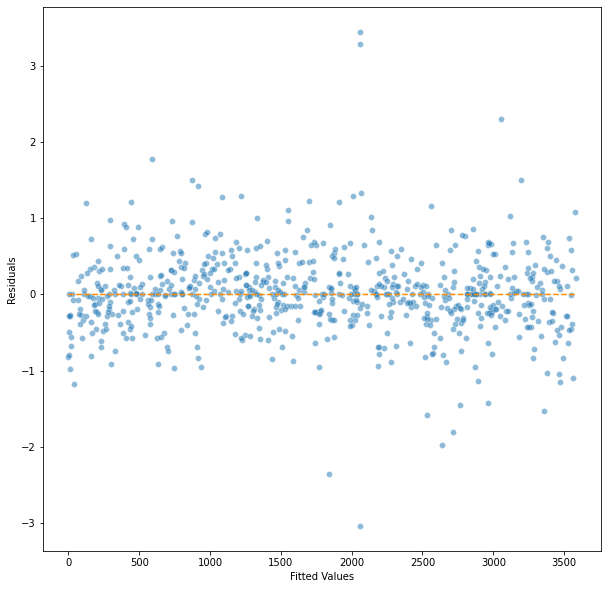

In [42]:
dtr2 = DecisionTreeRegressor()
dtr2_pipe = Pipeline([('preprocessor', preprocessor),
                      ('percen', SelectPercentile(percentile=50)),
                       ('tree', dtr2)
                     ])
dtr2_pipe.fit(X_train, y_train)
dtr_acc2 = price_taget(dtr2_pipe,X_train,y_train,X_test,y_test)

#### ``GradientBoostingRegressor``

Model Performance
MAE: 0.272
RMSE: 0.362
r2 : 0.69
Cross validation of the model
fit_time       0.379124
score_time     0.020623
test_score     0.649333
train_score    0.694005
dtype: float64
residual data frame
        Actual  Predicted  Residuals
2859  4.700480   5.395673  -0.695192
2905  4.189655   4.269469  -0.079814
893   3.931826   4.267468  -0.335643
483   3.931826   4.076925  -0.145100
1745  4.912655   4.369524   0.543131
3102  6.403574   5.677210   0.726364
2769  4.025352   4.179711  -0.154360
3557  4.110874   4.446051  -0.335177
844   5.860786   5.885721  -0.024935
3549  4.394449   4.663275  -0.268826
1410  5.703782   5.520999   0.182783
2418  5.135798   5.425165  -0.289366
256   4.488636   4.455180   0.033457
244   4.234107   4.442776  -0.208669
3550  4.736198   4.899400  -0.163202
2088  5.398163   5.200397   0.197766
2981  4.158883   4.242067  -0.083184
2321  5.940171   5.502615   0.437557
289   4.430817   4.403908   0.026909
2701  4.110874   4.215246  -0.104372


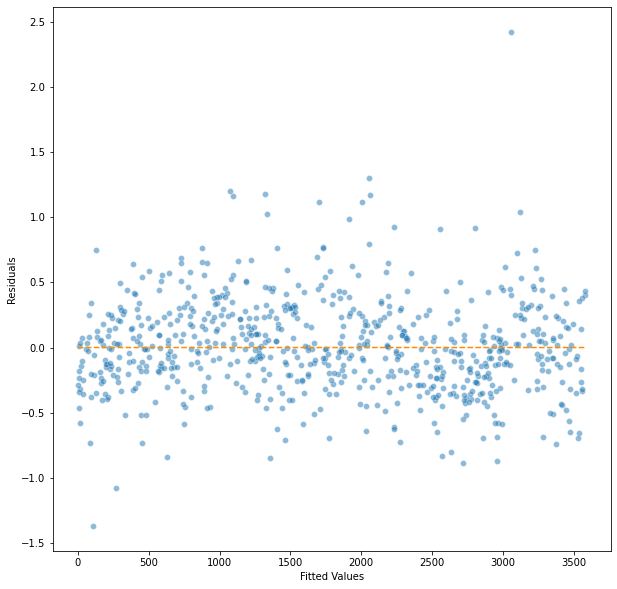

In [43]:
gbr2 = GradientBoostingRegressor()
gbr2_pipe = Pipeline([('preprocessor', preprocessor),
                     ('percen', SelectPercentile(percentile=50)),
                     ('boost',gbr2)
                     ])
gbr2_pipe.fit(X_train, y_train)
gbr_acc2 = price_taget(gbr2_pipe, X_train, y_train,X_test, y_test)

#### ``RandomForestRegressor``

Model Performance
MAE: 0.262
RMSE: 0.37
r2 : 0.677
Cross validation of the model
fit_time       1.045990
score_time     0.042109
test_score     0.621185
train_score    0.942265
dtype: float64
residual data frame
        Actual  Predicted  Residuals
2859  4.700480   5.403211  -0.702730
2905  4.189655   4.249980  -0.060326
893   3.931826   4.224825  -0.292999
483   3.931826   4.097489  -0.165663
1745  4.912655   4.068101   0.844554
3102  6.403574   6.158532   0.245043
2769  4.025352   4.337239  -0.311888
3557  4.110874   4.452403  -0.341529
844   5.860786   6.049193  -0.188407
3549  4.394449   4.712540  -0.318091
1410  5.703782   5.507219   0.196564
2418  5.135798   5.246249  -0.110450
256   4.488636   4.537493  -0.048857
244   4.234107   4.511544  -0.277437
3550  4.736198   4.874836  -0.138637
2088  5.398163   5.152002   0.246160
2981  4.158883   4.354690  -0.195807
2321  5.940171   5.439126   0.501045
289   4.430817   4.590087  -0.159270
2701  4.110874   4.218417  -0.107543


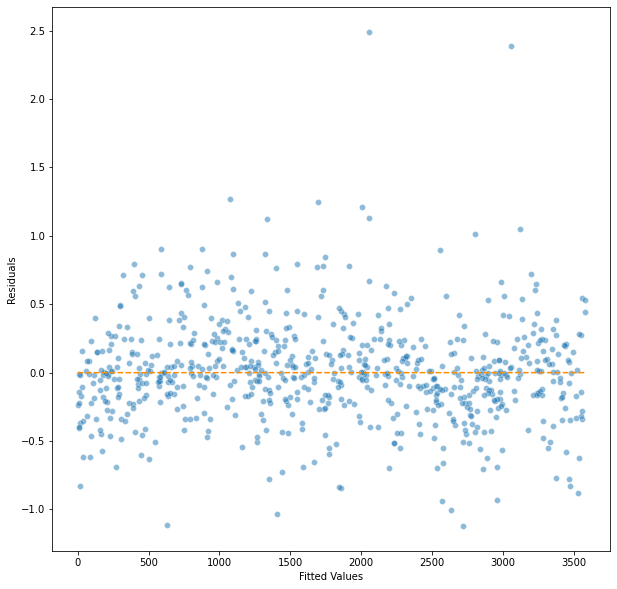

In [44]:
rfr2 = RandomForestRegressor()
rfr2_pipe = Pipeline(
    [('preprocessor', preprocessor),
     ('percen', SelectPercentile(percentile=50)),
     ('random_forest',rfr2)
    ])
rfr2_pipe.fit(X_train, y_train)
rfr_acc2 = price_taget(rfr2_pipe, X_train, y_train, X_test, y_test)

#### ``XGBRegressor``

Model Performance
MAE: 0.265
RMSE: 0.365
r2 : 0.686
Cross validation of the model
fit_time       0.505924
score_time     0.029688
test_score     0.634484
train_score    0.913812
dtype: float64
residual data frame
        Actual  Predicted  Residuals
2859  4.700480   5.443494  -0.743014
2905  4.189655   4.207989  -0.018334
893   3.931826   4.044291  -0.112466
483   3.931826   4.184279  -0.252453
1745  4.912655   4.580936   0.331719
3102  6.403574   5.886879   0.516695
2769  4.025352   4.446534  -0.421182
3557  4.110874   4.491468  -0.380595
844   5.860786   6.095239  -0.234453
3549  4.394449   4.834172  -0.439723
1410  5.703782   5.562643   0.141139
2418  5.135798   5.259317  -0.123518
256   4.488636   4.498301  -0.009664
244   4.234107   4.497251  -0.263145
3550  4.736198   4.817342  -0.081143
2088  5.398163   5.301173   0.096989
2981  4.158883   4.381007  -0.222124
2321  5.940171   5.505869   0.434302
289   4.430817   4.602752  -0.171935
2701  4.110874   4.328138  -0.217264


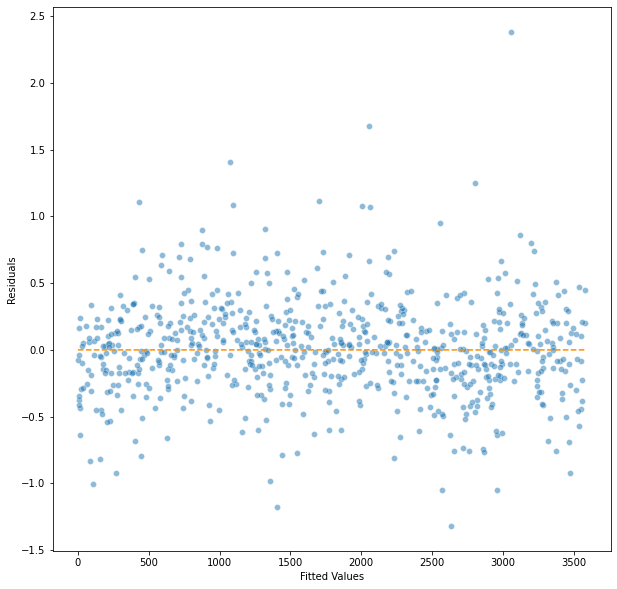

In [45]:
xgb2 = XGBRegressor()
xgb2_pipe = Pipeline([
    ('preprocessor', preprocessor),
     ('percen', SelectPercentile(percentile=50)),
     ('boost',xgb2)
    ])
xgb2_pipe.fit(X_train, y_train)
xgb_acc2 = price_taget(xgb2_pipe,X_train, y_train, X_test, y_test)

#### ``KNeighborsRegressor``

Model Performance
MAE: 0.288
RMSE: 0.385
r2 : 0.649
Cross validation of the model
fit_time       0.144778
score_time     0.041440
test_score     0.584499
train_score    0.718236
dtype: float64
residual data frame
        Actual  Predicted  Residuals
2859  4.700480   5.540925  -0.840445
2905  4.189655   4.292945  -0.103291
893   3.931826   4.321905  -0.390079
483   3.931826   4.011503  -0.079677
1745  4.912655   4.630203   0.282452
3102  6.403574   5.927647   0.475927
2769  4.025352   4.063445  -0.038094
3557  4.110874   4.501206  -0.390332
844   5.860786   6.087077  -0.226291
3549  4.394449   4.675634  -0.281184
1410  5.703782   5.299663   0.404119
2418  5.135798   5.325679  -0.189880
256   4.488636   4.603919  -0.115282
244   4.234107   4.388116  -0.154009
3550  4.736198   4.978485  -0.242287
2088  5.398163   5.271323   0.126840
2981  4.158883   4.368818  -0.209935
2321  5.940171   5.401646   0.538525
289   4.430817   4.349256   0.081561
2701  4.110874   4.515258  -0.404384


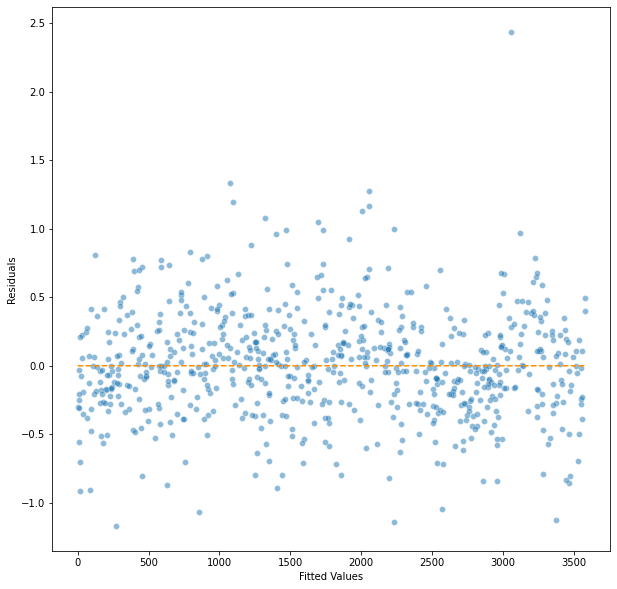

In [46]:
knr2 = KNeighborsRegressor()
knr2_pipe = Pipeline([('preprocessor', preprocessor),
                      ('percen', SelectPercentile(percentile=50)),
                     ('KNR',knr2),
                     ])
knr2_pipe.fit(X_train, y_train)
knr_acc2 = price_taget(knr2_pipe, X_train, y_train,X_test, y_test)

### 3. 3 Best Tune Model with Feature Selection

In this experiment i choose features by looking 

#### ``GradientBoostingRegressorTune``

In [ ]:
gbr3 = GradientBoostingRegressor()
gbr3_pipe = Pipeline(
    [('preprocessor', preprocessor),
     ('percen', SelectPercentile(percentile=50)),
     ('boost',gbr3)])
gbr3_param = {'boost__loss': ['ls', 'huber'], 'boost__criterion': ['mse', 'mae']}
gbr3_grid_search = GridSearchCV(gbr3_pipe, gbr3_param,scoring = 'r2', n_jobs=-1,verbose=1)
gbr3_grid_search.fit(X_train, y_train)
print(gbr3_grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [ ]:
gbr3_tuned = gbr3_grid_search.best_estimator_.fit(X_train, y_train)
y_pred_gbr3 = gbr3_tuned.predict(X_test)
X_pred_gbr3 = X_test
gbr_grid_acc3 = price_taget(gbr3_tuned, X_pred_gbr3, y_pred_gbr3, X_test, y_test)

#### ``RandomForestRegressorTune``

In [ ]:
rfr3 = RandomForestRegressor()
rfr3_pipe = Pipeline(
    [('preprocessor', preprocessor),
     ('percen', SelectPercentile(percentile=50)),
     ('random_forest',rfr3)])
rfr3_param = {'random_forest__n_estimators' : [100, 150, 200],
                        'random_forest__bootstrap' : [True,False],
                        'random_forest__min_samples_split' : [2,5,8,10,12]}

rfr3_grid_search = GridSearchCV(rfr3_pipe, rfr3_param, scoring ='r2',n_jobs=-1,verbose=1)
rfr3_grid_search.fit(X_train, y_train)
print(rfr3_grid_search.best_params_)

In [ ]:
rfr3_tuned = rfr3_grid_search.best_estimator_.fit(X_train, y_train)
y_pred_rfr3 = rfr3_tuned.predict(X_test)
X_pred_rfr3 = X_test
rfr_grid_acc3 = price_taget(rfr3_tuned, X_pred_rfr3, y_pred_rfr3, X_test, y_test)

#### ``XGBRegressorTune``

In [ ]:
xgb3 = XGBRegressor()
xgb3_pipe = Pipeline(
    [('preprocessor', preprocessor),
     ('percen', SelectPercentile(percentile=50)),
     ('boost',xgb3)])
xgb3_param = {'boost__n_estimators': [100, 150, 200],
              'boost__learning_rate': [0.01, 0.05, 0.1], 
              'boost__max_depth': [3, 4, 5, 6, 7],
              'boost__colsample_bytree': [0.6, 0.7, 1],
              'boost__gamma': [0.0, 0.1, 0.2]}
xgb3_grid_search = GridSearchCV(xgb3_pipe, xgb3_param, scoring ='r2', n_jobs=-1,verbose=1)
xgb3_grid_search.fit(X_train, y_train)
print(xgb3_grid_search.best_params_)

In [ ]:
xgb3_tuned = xgb3_grid_search.best_estimator_.fit(X_train, y_train)
y_pred_xgb3 = xgb3_tuned.predict(X_test)
X_pred_xgb3 = X_test
xgb_grid_acc3 = price_taget(xgb3_tuned, X_pred_xgb3, y_pred_xgb3, X_test, y_test)

### 4. Evaluation

### 4.1 Evaluation Base Model

In [ ]:
score_list_1 = [linreg_acc['score'], dtr_acc['score'],
            rfr_acc['score'], gbr_acc['score'],xgb_acc['score'],knr_acc['score']]

mae_list_1 = [linreg_acc['MAE'], dtr_acc['MAE'],
            rfr_acc['MAE'], gbr_acc['MAE'],xgb_acc['MAE'],knr_acc['MAE']]

rmse_list_1 = [linreg_acc['RMSE'], dtr_acc['RMSE'],
            rfr_acc['RMSE'], gbr_acc['RMSE'],xgb_acc['RMSE'],knr_acc['RMSE'MSE

r2_list_1 = [linreg_acc['R2'], dtr_acc['R2'],
            rfr_acc['R2'], gbr_acc['R2'],xgb_acc['R2'],knr_acc['R2']]

best_model_1 = pd.DataFrame({'MAE':mae_list_1,'RMSE':rmse_list_1,'R2':r2_list_1}, 
                          index ='LinearRegression DisicionTree GradienBoost RandomForest  XGBoost KNeighborsRegressor'.split(),
                        )
best_score_val_1 = pd.DataFrame(data = score_list_1, 
                          index ='LinearRegression DisicionTree GradienBoost RandomForest  XGBoost KNeighborsRegressor'.split(),
                        )
best_result_1 = pd.concat([best_model_1, best_score_val_1], axis=1)
best_result_1.drop(['fit_time','score_time'],axis=1, inplace=True)
best_result_1

### 4.3 3 Base Model with Feature Selection

In [ ]:
score_list_2 = [linreg_acc2['score'], dtr_acc2['score'],
            rfr_acc2['score'], gbr_acc2['score'],xgb_acc2['score'],knr_acc2['score']]

mae_list_2 = [linreg_acc2['MAE'], dtr_acc2['MAE'],
            rfr_acc2['MAE'], gbr_acc2['MAE'],xgb_acc2['MAE'],knr_acc2['MAE']]

rmse_list_2 = [linreg_acc2['RMSE'], dtr_acc2['RMSE'],
            rfr_acc2['RMSE'], gbr_acc2['RMSE'],xgb_acc2['RMSE'],knr_acc2['RMSE']]

r2_list_2 = [linreg_acc2['R2'], dtr_acc2['R2'],
            rfr_acc2['R2'], gbr_acc2['R2'],xgb_acc2['R2'],knr_acc2['R2']]

best_model_2 = pd.DataFrame({'MAE':mae_list_2,'RMSE':rmse_list_2,'R2':r2_list_2}, 
                          index ='LinearRegression DisicionTree GradienBoost RandomForest  XGBoost KNeighborsRegressor'.split(),
                        )
best_score_val_2 = pd.DataFrame(data = score_list_2, 
                          index ='LinearRegression DisicionTree GradienBoost RandomForest XGBoost KNeighborsRegressor'.split(),
                        )
best_result_2 = pd.concat([best_model_2, best_score_val_2], axis=1)
best_result_2.drop(['fit_time','score_time'],axis=1, inplace=True)
best_result_2

 ### 4.2 Evaluation Experimet with all features and hyperparameter

In [ ]:
score_list_3 = [rfr_grid_acc3['score'], gbr_grid_acc3['score'],xgb_grid_acc3['score']]

mae_list_3 = [rfr_acc3['MAE'], gbr_acc3['MAE'],xgb_acc3['MAE']]

rmse_list_3 = [rfr_acc3['RMSE'], gbr_acc3['RMSE'],xgb_acc3['RMSE']]

r2_list_3 = [rfr_grid_acc3['R2'], gbr_grid_acc3['R2'],xgb_grid_acc3['R2']]

best_model_3 = pd.DataFrame({'MAE':mae_list_3,'RMSE':rmse_list_3,'R2':r2_list_3}, 
                          index ='GradienBoost RandomForest  XGBoost'.split(),
                        )
best_score_val_3 = pd.DataFrame(data = score_list_3, 
                          index ='GradienBoost RandomForest XGBoost'.split(),
                        )
best_result_3 = pd.concat([best_model_3, best_score_val_3], axis=1)
best_result_3.drop(['fit_time','score_time'],axis=1, inplace=True)
best_result_3

dengan mempertimbangkan score R^2 terhadap data, 
terlihat bahwa **RandomForest** pada ekperimen yang saya buat dalam semua fitur yang dipilih adalah yang paling mendekati 1 dengan score sebelum di validasi **0,69** sedangkan setelah di validasi score nya adalah 
score test **0,96** dan score training **0.98**.

## DEPLOYMENT

In [ ]:
import pickle

In [ ]:
df['log_price'] = np.expm1(df['log_price'])

In [ ]:
df

In [ ]:
model = rfr3_tuned

In [ ]:
model

In [ ]:
filename = 'RandomForest.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
features = df.drop(['log_price'],axis=1)

In [ ]:
filename = 'features_dummies_coloumns.sav'
pickle.dump(features.columns, open(filename , 'wb'))

In [ ]:
filename = 'real_colomn.sav'
pickle.dump(df.drop('log_price',axis=1).columns, open(filename , 'wb'))

In [ ]:
model_load = pickle.load(open('RandomForest.sav','rb'))
one_hot_columns = pickle.load(open('features_dummies_coloumns.sav','rb'))

In [ ]:
model_load

In [ ]:
one_hot_columns

In [ ]:
df.to_csv('listings_Final.csv', index=False)